In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import hdbscan
from sklearn.neighbors import NearestNeighbors
import folium
from folium.plugins import HeatMap, MarkerCluster
from pathlib import Path
from tqdm import tqdm

PATH_FINAL = "/content/final_modeling_features_complete.csv"
PATH_POINTS_DBSCAN = "/content/points_with_dbscan.csv"
PATH_GRID = "/content/grid_cells.csv"
PATH_PRED_MAP = "/content/pred_map_2024.csv"
PATH_PRED_HTML = "/content/predicted_hotspots_map_2024.html"

print("Loading final modeling features (may be large)...")
df_final = pd.read_csv(PATH_FINAL)
print("Loaded final features shape:", df_final.shape)

print("Loading point-level DBSCAN labels...")
points_db = pd.read_csv(PATH_POINTS_DBSCAN)
print("Loaded points_with_dbscan shape:", points_db.shape)

print("Loading grid metadata (centroids)...")
grid_df = pd.read_csv(PATH_GRID)
print("Loaded grid_cells shape:", grid_df.shape)

if Path(PATH_PRED_MAP).exists():
    pred_map = pd.read_csv(PATH_PRED_MAP)
    print("Loaded pred_map_2024 shape:", pred_map.shape)
else:
    pred_map = None
    print("pred_map_2024.csv not found.")

print("\nQuick value checks:")
print("Unique years in final features:", sorted(df_final['iso_year'].unique()))
print("Sample cluster columns in final features (if present):", [c for c in df_final.columns if 'cluster' in c][:10])
display(df_final.head())
display(points_db.head())
display(grid_df.head())

Loading final modeling features (may be large)...
Loaded final features shape: (362612, 26)
Loading point-level DBSCAN labels...
Loaded points_with_dbscan shape: (1646528, 8)
Loading grid metadata (centroids)...
Loaded grid_cells shape: (12416, 9)
Loaded pred_map_2024 shape: (68156, 30)

Quick value checks:
Unique years in final features: [np.int64(2022), np.int64(2023), np.int64(2024), np.int64(2025)]
Sample cluster columns in final features (if present): ['is_cluster', 'was_cluster_prev', 'cluster_age', 'cluster_change']


,grid_id,iso_year,iso_week,crime_count,lag_1,lag_2,avg_2wk,trend_2wk,hotspot,kde_score,...,distinct_offense_count,offense_entropy,off_ASSAULT_3_&_RELATED_OFFENSES,off_CRIMINAL_MISCHIEF_&_RELATED_OF,off_FELONY_ASSAULT,off_GRAND_LARCENY,off_HARRASSMENT_2,off_OFF._AGNST_PUB_ORD_SENSBLTY_&,off_PETIT_LARCENY,off_VEHICLE_AND_TRAFFIC_LAWS
0,G_10_10,2022,5,2,2.0,2.0,2.0,0.0,0,2.035706,...,1,-1.000089e-12,0,0,0,0,2,0,0,0
1,G_10_10,2022,11,2,2.0,2.0,2.0,0.0,0,2.171366,...,2,6.931472e-01,0,0,1,0,0,0,0,0
2,G_10_10,2022,14,1,2.0,2.0,2.0,0.0,0,2.725830,...,1,-1.000089e-12,0,0,0,0,1,0,0,0
3,G_10_10,2022,15,1,1.0,2.0,1.5,-1.0,0,1.375662,...,1,-1.000089e-12,0,0,0,0,1,0,0,0
4,G_10_10,2022,16,1,1.0,1.0,1.0,0.0,0,1.332424,...,1,-1.000089e-12,0,0,0,0,0,1,0,0


,lat,lon,date,grid_id,iso_year,iso_week,dbscan_cluster,in_cluster
0,40.769926,-73.888860,2024-12-30,G_62_83,2025,1,0,1
1,40.711274,-73.984350,2024-12-30,G_49_62,2025,1,0,1
2,40.678520,-73.983808,2024-12-30,G_42_62,2025,1,0,1
3,40.740316,-73.759881,2024-12-30,G_55_112,2025,1,7,1
4,40.750884,-73.717741,2024-12-30,G_58_121,2025,1,0,1


,grid_id,lat_min,lat_max,lon_min,lon_max,centroid_lat,centroid_lon,i,j
0,G_0_0,40.489315,40.493815,-74.264741,-74.260241,40.491565,-74.262491,0,0
1,G_0_1,40.489315,40.493815,-74.260241,-74.255741,40.491565,-74.257991,0,1
2,G_0_2,40.489315,40.493815,-74.255741,-74.251241,40.491565,-74.253491,0,2
3,G_0_3,40.489315,40.493815,-74.251241,-74.246741,40.491565,-74.248991,0,3
4,G_0_4,40.489315,40.493815,-74.246741,-74.242241,40.491565,-74.244491,0,4


In [4]:
try:
    import hdbscan
except Exception as e:
    raise ImportError("hdbscan not available in this environment. Please install it: pip install hdbscan") from e

from sklearn.neighbors import NearestNeighbors

MAX_SAMPLE = 200000
MIN_CLUSTER_SIZE = 50
MIN_SAMPLES = 10
ASSIGN_DIST = 0.006

points = points_db.copy()
n_points = len(points)
print("Total points:", n_points)

if n_points > MAX_SAMPLE:
    sample_idx = points.sample(MAX_SAMPLE, random_state=1).index.values
    sample_pts = points.loc[sample_idx].reset_index(drop=True)
    remaining_idx = points.index.difference(sample_idx)
    print(f"Using sampled {len(sample_pts)} points for HDBSCAN; remaining {len(remaining_idx)} will be assigned by nearest matching.")
else:
    sample_idx = points.index.values
    sample_pts = points.copy().reset_index(drop=True)
    remaining_idx = np.array([], dtype=int)
    print("Using all points for HDBSCAN (no subsampling).")

coords_sample = sample_pts[['lat','lon']].values

clusterer = hdbscan.HDBSCAN(min_cluster_size=MIN_CLUSTER_SIZE, min_samples=MIN_SAMPLES, metric='euclidean')
print("Fitting HDBSCAN on sample...")
labels_sample = clusterer.fit_predict(coords_sample)
sample_pts['hdbscan_cluster'] = labels_sample
n_clusters = len(set(labels_sample)) - (1 if -1 in labels_sample else 0)
print("HDBSCAN done. Number of clusters (excluding -1):", n_clusters)

full_labels = np.full(n_points, -1, dtype=int)

for idx, lab in zip(sample_idx, labels_sample):
    full_labels[idx] = int(lab)

if len(remaining_idx) > 0:
    nn = NearestNeighbors(n_neighbors=1, algorithm='auto', n_jobs=-1).fit(coords_sample)
    rem_coords = points.loc[remaining_idx, ['lat','lon']].values
    dists, idxs = nn.kneighbors(rem_coords, return_distance=True)
    dists = dists.ravel()
    idxs = idxs.ravel()
    for i, (pt_idx, dist, nn_idx) in enumerate(zip(remaining_idx, dists, idxs)):
        if dist <= ASSIGN_DIST:
            full_labels[pt_idx] = int(labels_sample[nn_idx])
        else:
            full_labels[pt_idx] = -1

points['hdbscan_cluster'] = full_labels
print("Assigned HDBSCAN labels to all points. Unique labels (incl -1):", np.unique(full_labels)[:30])

print("Top HDBSCAN cluster sizes:")
print(points['hdbscan_cluster'].value_counts().head(10))

points['hdbscan_in_cluster'] = (points['hdbscan_cluster'] != -1).astype(int)

grid_week_hdb = (
    points.groupby(['grid_id','iso_year','iso_week'])['hdbscan_in_cluster']
          .max()
          .reset_index()
          .rename(columns={'hdbscan_in_cluster':'hdbscan_is_cluster'})
)

final = df_final.copy()

final = final.merge(grid_week_hdb, on=['grid_id','iso_year','iso_week'], how='left')
final['hdbscan_is_cluster'] = final['hdbscan_is_cluster'].fillna(0).astype(int)

final = final.sort_values(['grid_id','iso_year','iso_week']).reset_index(drop=True)
final['hdbscan_was_cluster_prev'] = final.groupby('grid_id')['hdbscan_is_cluster'].shift(1).fillna(0).astype(int)

# cluster_age
def compute_age(arr):
    ages = []
    cur = 0
    for v in arr:
        if v == 1:
            cur += 1
        else:
            cur = 0
        ages.append(cur)
    return ages

final['hdbscan_cluster_age'] = final.groupby('grid_id')['hdbscan_is_cluster'].transform(lambda g: compute_age(g.values))

# cluster change: emerging=1, cooling=-1, stable=0
final['hdbscan_cluster_change'] = 0
final.loc[(final['hdbscan_is_cluster']==1) & (final['hdbscan_was_cluster_prev']==0), 'hdbscan_cluster_change'] = 1
final.loc[(final['hdbscan_is_cluster']==0) & (final['hdbscan_was_cluster_prev']==1), 'hdbscan_cluster_change'] = -1

final_out = "/content/final_modeling_features_with_hdbscan.csv"
points_out = "/content/points_with_hdbscan.csv"
final.to_csv(final_out, index=False)
points.to_csv(points_out, index=False)

print("Saved final with HDBSCAN features to:", final_out)
print("Saved point-level HDBSCAN labels to:", points_out)
print("Final shape:", final.shape)
final.head()

Total points: 1646528
Using sampled 200000 points for HDBSCAN; remaining 1446528 will be assigned by nearest matching.
Fitting HDBSCAN on sample...


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


HDBSCAN done. Number of clusters (excluding -1): 1102
Assigned HDBSCAN labels to all points. Unique labels (incl -1): [-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26 27 28]
Top HDBSCAN cluster sizes:
hdbscan_cluster
-1      650345
 426      5072
 150      4646
 684      4602
 732      4469
 260      4115
 29       3899
 627      3859
 731      3593
 54       3591
Name: count, dtype: int64
Saved final with HDBSCAN features to: /content/final_modeling_features_with_hdbscan.csv
Saved point-level HDBSCAN labels to: /content/points_with_hdbscan.csv
Final shape: (362612, 30)


,grid_id,iso_year,iso_week,crime_count,lag_1,lag_2,avg_2wk,trend_2wk,hotspot,kde_score,...,off_FELONY_ASSAULT,off_GRAND_LARCENY,off_HARRASSMENT_2,off_OFF._AGNST_PUB_ORD_SENSBLTY_&,off_PETIT_LARCENY,off_VEHICLE_AND_TRAFFIC_LAWS,hdbscan_is_cluster,hdbscan_was_cluster_prev,hdbscan_cluster_age,hdbscan_cluster_change
0,G_10_10,2022,5,2,2.0,2.0,2.0,0.0,0,2.035706,...,0,0,2,0,0,0,0,0,0,0
1,G_10_10,2022,11,2,2.0,2.0,2.0,0.0,0,2.171366,...,1,0,0,0,0,0,1,0,1,1
2,G_10_10,2022,14,1,2.0,2.0,2.0,0.0,0,2.725830,...,0,0,1,0,0,0,1,1,2,0
3,G_10_10,2022,15,1,1.0,2.0,1.5,-1.0,0,1.375662,...,0,0,1,0,0,0,1,1,3,0
4,G_10_10,2022,16,1,1.0,1.0,1.0,0.0,0,1.332424,...,0,0,0,1,0,0,1,1,4,0


In [5]:
# Cluster comparison: DBSCAN vs HDBSCAN overlap and stability

import pandas as pd
import numpy as np

df_compare = final.copy()

db_cols = [c for c in df_compare.columns if 'cluster' in c]
print("Detected cluster-related columns:", db_cols)

df_compare['both_cluster'] = (
    (df_compare['is_cluster'] == 1) &
    (df_compare['hdbscan_is_cluster'] == 1)
).astype(int)

df_compare['either_cluster'] = (
    (df_compare['is_cluster'] == 1) |
    (df_compare['hdbscan_is_cluster'] == 1)
).astype(int)

overlap_summary = {
    "DBSCAN_cluster_count": int(df_compare['is_cluster'].sum()),
    "HDBSCAN_cluster_count": int(df_compare['hdbscan_is_cluster'].sum()),
    "Both_overlap": int(df_compare['both_cluster'].sum()),
    "Either_cluster": int(df_compare['either_cluster'].sum())
}

print("\n=== OVERLAP SUMMARY (DBSCAN vs HDBSCAN) ===")
for k, v in overlap_summary.items():
    print(f"{k:25s}: {v}")

# Jaccard similarity
jaccard = overlap_summary["Both_overlap"] / overlap_summary["Either_cluster"]
print(f"\nJaccard similarity (cluster membership): {jaccard:.4f}")

week_overlap = (
    df_compare.groupby(['iso_year','iso_week'])
              .agg(
                  dbscan_clusters = ('is_cluster','sum'),
                  hdbscan_clusters = ('hdbscan_is_cluster','sum'),
                  overlap = ('both_cluster','sum')
              )
              .reset_index()
)

week_overlap['overlap_ratio'] = week_overlap['overlap'] / week_overlap['dbscan_clusters'].replace(0, np.nan)

print("\n=== Weekly Overlap (head) ===")
display(week_overlap.head())

stability = (
    df_compare.groupby('grid_id')
              .agg(
                  weeks_in_cluster = ('hdbscan_is_cluster','sum'),
                  transitions = ('hdbscan_cluster_change', lambda x: (x!=0).sum()),
                  max_age = ('hdbscan_cluster_age','max')
              )
              .reset_index()
)

print("\n=== Cluster Stability Summary (head) ===")
display(stability.head())

week_overlap.to_csv("/content/cluster_week_overlap.csv", index=False)
stability.to_csv("/content/hdbscan_cluster_stability.csv", index=False)

print("\nSaved:")
print(" - /content/cluster_week_overlap.csv")
print(" - /content/hdbscan_cluster_stability.csv")

Detected cluster-related columns: ['is_cluster', 'was_cluster_prev', 'cluster_age', 'cluster_change', 'hdbscan_is_cluster', 'hdbscan_was_cluster_prev', 'hdbscan_cluster_age', 'hdbscan_cluster_change']

=== OVERLAP SUMMARY (DBSCAN vs HDBSCAN) ===
DBSCAN_cluster_count     : 349206
HDBSCAN_cluster_count    : 228879
Both_overlap             : 224020
Either_cluster           : 354065

Jaccard similarity (cluster membership): 0.6327

=== Weekly Overlap (head) ===


,iso_year,iso_week,dbscan_clusters,hdbscan_clusters,overlap,overlap_ratio
0,2022,2,637,533,532,0.835165
1,2022,3,1585,1172,1164,0.734385
2,2022,4,1811,1240,1233,0.680839
3,2022,5,1934,1301,1296,0.670114
4,2022,6,2043,1383,1369,0.670093



=== Cluster Stability Summary (head) ===


,grid_id,weeks_in_cluster,transitions,max_age
0,G_10_10,53,37,7
1,G_10_11,43,1,43
2,G_10_12,27,24,5
3,G_10_13,11,15,2
4,G_10_14,47,19,26



Saved:
 - /content/cluster_week_overlap.csv
 - /content/hdbscan_cluster_stability.csv


In [7]:
# weekly crime-type matrix per grid cell
print("Loading cleaned NYPD dataset with grid_id...")
df = pd.read_csv("/content/cleaned_with_grid.csv")

df['date'] = pd.to_datetime(df['date'], errors='coerce')
df['iso_year'] = df['date'].dt.isocalendar().year
df['iso_week'] = df['date'].dt.isocalendar().week

top_offenses = [
    'PETIT LARCENY',
    'HARRASSMENT 2',
    'ASSAULT 3 & RELATED OFFENSES',
    'GRAND LARCENY',
    'CRIMINAL MISCHIEF & RELATED OF',
    'FELONY ASSAULT',
    'VEHICLE AND TRAFFIC LAWS',
    'OFF. AGNST PUB ORD SENSBLTY &'
]

df_off = df[df['offense'].isin(top_offenses)].copy()

print("Filtered dataset shape:", df_off.shape)

weekly_offense = (
    df_off.groupby(['grid_id', 'iso_year', 'iso_week', 'offense'])
          .size()
          .unstack(fill_value=0)
          .reset_index()
)

print("Weekly offense matrix shape:", weekly_offense.shape)
weekly_offense.head()

weekly_offense.to_csv("/content/weekly_offense_matrix.csv", index=False)
print("Saved weekly offense matrix to /content/weekly_offense_matrix.csv")

Loading cleaned NYPD dataset with grid_id...
Filtered dataset shape: (1230275, 16)
Weekly offense matrix shape: (336228, 11)
Saved weekly offense matrix to /content/weekly_offense_matrix.csv


Offense columns: ['ASSAULT 3 & RELATED OFFENSES', 'CRIMINAL MISCHIEF & RELATED OF', 'FELONY ASSAULT', 'GRAND LARCENY', 'HARRASSMENT 2', 'OFF. AGNST PUB ORD SENSBLTY &', 'PETIT LARCENY', 'VEHICLE AND TRAFFIC LAWS']

=== Jaccard Similarity Matrix (head) ===


,ASSAULT 3 & RELATED OFFENSES,CRIMINAL MISCHIEF & RELATED OF,FELONY ASSAULT,GRAND LARCENY,HARRASSMENT 2,OFF. AGNST PUB ORD SENSBLTY &,PETIT LARCENY,VEHICLE AND TRAFFIC LAWS
ASSAULT 3 & RELATED OFFENSES,1.000000,0.227818,0.220562,0.217973,0.294187,0.142419,0.263261,0.140315
CRIMINAL MISCHIEF & RELATED OF,0.227818,1.000000,0.171226,0.192633,0.234137,0.124156,0.225699,0.122561
FELONY ASSAULT,0.220562,0.171226,1.000000,0.157524,0.196425,0.124273,0.174280,0.121797
GRAND LARCENY,0.217973,0.192633,0.157524,1.000000,0.228670,0.116988,0.258388,0.117964
HARRASSMENT 2,0.294187,0.234137,0.196425,0.228670,1.000000,0.142787,0.298748,0.136784


Saved offense_jaccard_matrix.csv


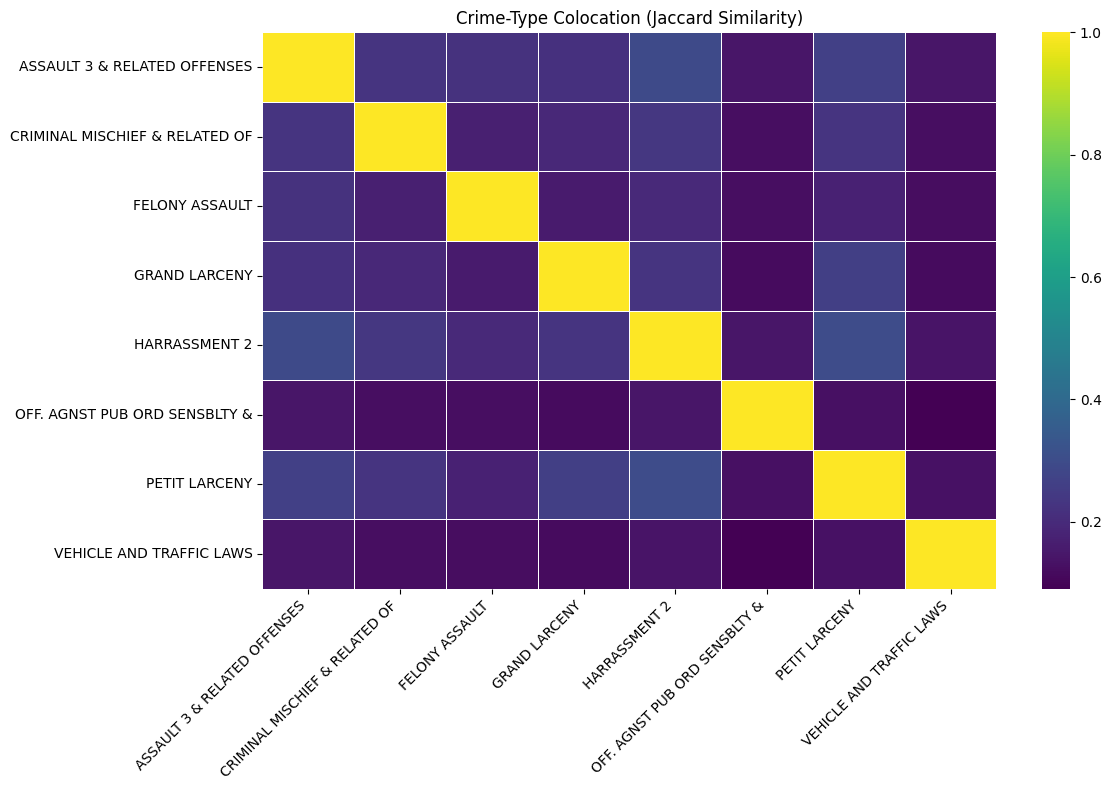


=== Top 10 Crime-Type Co-Location Pairs ===
HARRASSMENT 2                             <-->  PETIT LARCENY                              Jaccard=0.299
ASSAULT 3 & RELATED OFFENSES              <-->  HARRASSMENT 2                              Jaccard=0.294
ASSAULT 3 & RELATED OFFENSES              <-->  PETIT LARCENY                              Jaccard=0.263
GRAND LARCENY                             <-->  PETIT LARCENY                              Jaccard=0.258
CRIMINAL MISCHIEF & RELATED OF            <-->  HARRASSMENT 2                              Jaccard=0.234
GRAND LARCENY                             <-->  HARRASSMENT 2                              Jaccard=0.229
ASSAULT 3 & RELATED OFFENSES              <-->  CRIMINAL MISCHIEF & RELATED OF             Jaccard=0.228
CRIMINAL MISCHIEF & RELATED OF            <-->  PETIT LARCENY                              Jaccard=0.226
ASSAULT 3 & RELATED OFFENSES              <-->  FELONY ASSAULT                             Jaccard=0.221
ASSAULT 3 

In [8]:
# Crime-Type Co-Occurrence Analysis with Jaccard Heatmap

weekly = pd.read_csv("/content/weekly_offense_matrix.csv")

offense_cols = [c for c in weekly.columns if c not in ['grid_id','iso_year','iso_week']]

print("Offense columns:", offense_cols)

# Convert counts → binary presence
binary_weekly = weekly.copy()
binary_weekly[offense_cols] = (binary_weekly[offense_cols] > 0).astype(int)

co_matrix = pd.DataFrame(0, index=offense_cols, columns=offense_cols, dtype=float)

for a in offense_cols:
    for b in offense_cols:
        A = binary_weekly[a]
        B = binary_weekly[b]

        # Jaccard similarity = |A ∩ B| / |A ∪ B|
        intersection = ((A == 1) & (B == 1)).sum()
        union = ((A == 1) | (B == 1)).sum()

        co_matrix.loc[a, b] = intersection / union if union > 0 else 0

print("\n=== Jaccard Similarity Matrix (head) ===")
display(co_matrix.head())

co_matrix.to_csv("/content/offense_jaccard_matrix.csv")
print("Saved offense_jaccard_matrix.csv")

plt.figure(figsize=(12, 8))
sns.heatmap(co_matrix, annot=False, cmap="viridis", linewidths=.5)
plt.title("Crime-Type Colocation (Jaccard Similarity)")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

pairs = []
for a in offense_cols:
    for b in offense_cols:
        if a < b:
            pairs.append((a, b, co_matrix.loc[a, b]))

pairs_sorted = sorted(pairs, key=lambda x: x[2], reverse=True)

print("\n=== Top 10 Crime-Type Co-Location Pairs ===")
for a, b, score in pairs_sorted[:10]:
    print(f"{a:40s}  <-->  {b:40s}   Jaccard={score:.3f}")

In [9]:
# Multi-Crime Hotspot Detection

weekly = pd.read_csv("/content/weekly_offense_matrix.csv")
offense_cols = [c for c in weekly.columns if c not in ['grid_id','iso_year','iso_week']]

print("Offense columns:", offense_cols)
weekly['multi_crime_count'] = (weekly[offense_cols] > 0).sum(axis=1)

weekly['multi_crime_weighted'] = weekly[offense_cols].sum(axis=1)

weekly['multi_hotspot'] = 0

for (y, w), group in weekly.groupby(['iso_year','iso_week']):
    cutoff = group['multi_crime_weighted'].quantile(0.90)
    weekly.loc[(weekly['iso_year']==y)&(weekly['iso_week']==w)&
               (weekly['multi_crime_weighted']>=cutoff), 'multi_hotspot'] = 1

print("Example rows:")
display(weekly.head())
weekly = weekly.sort_values(['grid_id','iso_year','iso_week'])
weekly['multi_prev'] = weekly.groupby('grid_id')['multi_hotspot'].shift(1).fillna(0)
weekly['multi_change'] = 0
weekly.loc[(weekly['multi_hotspot']==1) & (weekly['multi_prev']==0), 'multi_change'] = 1
weekly.loc[(weekly['multi_hotspot']==0) & (weekly['multi_prev']==1), 'multi_change'] = -1

def compute_age(arr):
    ages = []
    cur = 0
    for v in arr:
        if v == 1:
            cur += 1
        else:
            cur = 0
        ages.append(cur)
    return ages

weekly['multi_age'] = weekly.groupby('grid_id')['multi_hotspot'].transform(lambda g: compute_age(g.values))

summary = (
    weekly.groupby('grid_id')
          .agg(
              weeks_multi=('multi_hotspot','sum'),
              transitions=('multi_change', lambda x: (x!=0).sum()),
              max_age=('multi_age','max')
          )
          .reset_index()
)

print("Multi-Crime Hotspot Summary:")
display(summary.head())

weekly.to_csv("/content/multicrime_hotspots.csv", index=False)
summary.to_csv("/content/multicrime_summary.csv", index=False)

print("Saved:")
print(" - multicrime_hotspots.csv")
print(" - multicrime_summary.csv")

Offense columns: ['ASSAULT 3 & RELATED OFFENSES', 'CRIMINAL MISCHIEF & RELATED OF', 'FELONY ASSAULT', 'GRAND LARCENY', 'HARRASSMENT 2', 'OFF. AGNST PUB ORD SENSBLTY &', 'PETIT LARCENY', 'VEHICLE AND TRAFFIC LAWS']
Example rows:


,grid_id,iso_year,iso_week,ASSAULT 3 & RELATED OFFENSES,CRIMINAL MISCHIEF & RELATED OF,FELONY ASSAULT,GRAND LARCENY,HARRASSMENT 2,OFF. AGNST PUB ORD SENSBLTY &,PETIT LARCENY,VEHICLE AND TRAFFIC LAWS,multi_crime_count,multi_crime_weighted,multi_hotspot
0,G_10_10,2022,1,0,0,0,1,1,0,0,0,2,2,0
1,G_10_10,2022,4,0,0,0,0,2,0,0,0,1,2,0
2,G_10_10,2022,5,0,0,0,0,2,0,0,0,1,2,0
3,G_10_10,2022,11,0,0,1,0,0,0,0,0,1,1,0
4,G_10_10,2022,14,0,0,0,0,1,0,0,0,1,1,0


Multi-Crime Hotspot Summary:


,grid_id,weeks_multi,transitions,max_age
0,G_10_10,0,0,0
1,G_10_11,0,0,0
2,G_10_12,0,0,0
3,G_10_13,0,0,0
4,G_10_14,0,0,0


Saved:
 - multicrime_hotspots.csv
 - multicrime_summary.csv


In [18]:
# Base map
nyc_center = [40.7128, -74.0060]
m = folium.Map(location=nyc_center, zoom_start=11, tiles="CartoDB positron")
m

In [24]:
import os
from folium import FeatureGroup

possible_paths = [
    "/content/final_modeling_features_with_hdbscan.csv",
    "/content/final_modeling_features_complete.csv",
    "/content/final_modeling_features.csv"
]
for p in possible_paths:
    if os.path.exists(p):
        features_path = p
        break
else:
    raise FileNotFoundError("No final features CSV found. Expected one of: " + ", ".join(possible_paths))

print("Using features file:", features_path)
df_feat = pd.read_csv(features_path)

if 'grid_df' not in globals():
    grid_df = pd.read_csv("/content/grid_cells.csv")

latest_year = int(df_feat['iso_year'].max())
latest_week = int(df_feat[df_feat['iso_year']==latest_year]['iso_week'].max())
print("Latest snapshot:", latest_year, "week", latest_week)

df_latest = df_feat[(df_feat['iso_year']==latest_year) & (df_feat['iso_week']==latest_week)].copy()
print("Rows in latest snapshot:", len(df_latest))

df_map = df_latest.merge(grid_df[['grid_id','centroid_lat','centroid_lon']], on='grid_id', how='left')
df_map = df_map.dropna(subset=['centroid_lat','centroid_lon'])

if 'kde_norm' in df_map.columns:
    weights = df_map['kde_norm'].astype(float).values
else:
    w = df_map['kde_score'].astype(float).values
    weights = (w - w.min()) / (w.max() - w.min() + 1e-9)

weights = np.clip(weights, 0, 1)
heat_data = df_map[['centroid_lat','centroid_lon']].values.tolist()
heat_data = [[lat, lon, float(w)] for (lat, lon), w in zip(df_map[['centroid_lat','centroid_lon']].values.tolist(), weights)]

fg_kde = FeatureGroup(name=f"KDE (latest {latest_year} W{latest_week})", show=True)
HeatMap(heat_data, radius=25, blur=15, max_zoom=13).add_to(fg_kde)
m.add_child(fg_kde)

from folium import LayerControl
LayerControl().add_to(m)

m

Output hidden; open in https://colab.research.google.com to view.

In [28]:
if 'df_map' not in globals():
    features_path = "/content/final_modeling_features_with_hdbscan.csv"
    df_feat = pd.read_csv(features_path)
    latest_year = int(df_feat['iso_year'].max())
    latest_week = int(df_feat[df_feat['iso_year']==latest_year]['iso_week'].max())
    df_latest = df_feat[(df_feat['iso_year']==latest_year) & (df_feat['iso_week']==latest_week)].copy()
    grid_df = pd.read_csv("/content/grid_cells.csv")
    df_map = df_latest.merge(grid_df[['grid_id','centroid_lat','centroid_lon']], on='grid_id', how='left').dropna(subset=['centroid_lat','centroid_lon'])

if 'db_hot' not in globals():
    points_db = pd.read_csv("/content/points_with_dbscan.csv")
    dom = points_db.groupby('grid_id')['dbscan_cluster'].agg(lambda s: s.value_counts().index[0] if len(s)>0 else -1).reset_index()
    dom = dom.rename(columns={'dbscan_cluster':'dbscan_grid_cluster'})
    df_map = df_map.merge(dom, on='grid_id', how='left')
    db_hot = df_map[df_map['is_cluster']==1].copy()

nyc_center = [40.7128, -74.0060]
m = folium.Map(location=nyc_center, zoom_start=11, tiles="CartoDB positron")

if 'kde_norm' in df_map.columns:
    weights = df_map['kde_norm'].astype(float).values
else:
    w = df_map['kde_score'].astype(float).values
    weights = (w - w.min()) / (w.max() - w.min() + 1e-9)
weights = np.clip(weights, 0, 1)
heat_data = [[lat, lon, float(w)] for (lat, lon), w in zip(df_map[['centroid_lat','centroid_lon']].values.tolist(), weights)]

fg_kde = FeatureGroup(name=f"KDE (latest {latest_year} W{latest_week}) - BLUE", show=True)
HeatMap(heat_data, radius=18, blur=20, max_zoom=13, min_opacity=0.2).add_to(fg_kde)
m.add_child(fg_kde)

kde_cmap = branca.colormap.LinearColormap(['#f7fbff','#6baed6','#08306b'], vmin=weights.min(), vmax=weights.max())
kde_cmap.caption = 'KDE intensity (normalized)'
m.add_child(kde_cmap)

fg_db = FeatureGroup(name=f"DBSCAN clusters (top) - PURPLE", show=False)

TOP_N_CLUSTERS = 25
points_db = pd.read_csv("/content/points_with_dbscan.csv")
cluster_sizes = points_db['dbscan_cluster'].value_counts().reset_index()
cluster_sizes.columns = ['dbscan_cluster','count']
cluster_sizes = cluster_sizes[cluster_sizes['dbscan_cluster'] != -1]
top_clusters = cluster_sizes.nlargest(TOP_N_CLUSTERS, 'count')['dbscan_cluster'].tolist()

if 'dbscan_grid_cluster' not in db_hot.columns:
    dom = points_db.groupby('grid_id')['dbscan_cluster'].agg(lambda s: s.value_counts().index[0] if len(s)>0 else -1).reset_index()
    dom = dom.rename(columns={'dbscan_cluster':'dbscan_grid_cluster'})
    db_hot = db_hot.merge(dom, on='grid_id', how='left')

db_plot = db_hot[db_hot['dbscan_grid_cluster'].isin(top_clusters)].copy()

for r in db_plot.itertuples():
    lat = float(r.centroid_lat)
    lon = float(r.centroid_lon)
    cid = int(getattr(r, 'dbscan_grid_cluster', -1))
    age = float(getattr(r, 'cluster_age', 1))
    radius = 3 + (age / max(1, db_plot['cluster_age'].max())) * 14
    popup = f"grid: {r.grid_id}<br>dbscan_cluster_id: {cid}<br>age: {age}<br>crime_count:{getattr(r,'crime_count',0)}"
    folium.CircleMarker(
        location=(lat, lon),
        radius=radius,
        weight=1,
        color='black',
        fill=True,
        fill_color='#6a0dad',
        fill_opacity=0.9,
        popup=popup
    ).add_to(fg_db)

m.add_child(fg_db)

if 'hdbscan_is_cluster' in df_map.columns:
    fg_hdb = FeatureGroup(name=f"HDBSCAN clusters - GRADIENT", show=False)
    ages = df_map.loc[df_map['hdbscan_is_cluster']==1, 'hdbscan_cluster_age'].fillna(0).astype(float)
    if len(ages)>0:
        vmin, vmax = ages.min(), ages.max()
    else:
        vmin, vmax = 0, 1
    cmap = branca.colormap.LinearColormap(['green','yellow','red'], vmin=vmin, vmax=vmax)
    for r in df_map[df_map['hdbscan_is_cluster']==1].itertuples():
        folium.CircleMarker(
            location=(r.centroid_lat, r.centroid_lon),
            radius=3 + (getattr(r,'hdbscan_cluster_age',0)/max(1,vmax))*12,
            color=None,
            fill=True,
            fill_color=cmap(getattr(r,'hdbscan_cluster_age',0)),
            fill_opacity=0.6,
            popup=f"grid:{r.grid_id}<br>hdb_age:{getattr(r,'hdbscan_cluster_age',0)}"
        ).add_to(fg_hdb)
    cmap.caption = 'HDBSCAN cluster age (weeks)'
    m.add_child(cmap)
    m.add_child(fg_hdb)

if os.path.exists("/content/multicrime_hotspots.csv"):
    mc = pd.read_csv("/content/multicrime_hotspots.csv")
    mc_latest = mc[(mc['iso_year']==latest_year)&(mc['iso_week']==latest_week)].copy()
    mc_map = mc_latest.merge(grid_df[['grid_id','centroid_lat','centroid_lon']], on='grid_id', how='left').dropna()
    fg_mc = FeatureGroup(name="Multi-crime hotspots (top10%)", show=False)
    for r in mc_map.itertuples():
        folium.CircleMarker(
            location=(r.centroid_lat, r.centroid_lon),
            radius=6,
            color='red',
            fill=True,
            fill_color='red',
            fill_opacity=0.8,
            popup=f"grid:{r.grid_id}<br>multi_count:{getattr(r,'multi_crime_weighted',0)}"
        ).add_to(fg_mc)
    m.add_child(fg_mc)

if os.path.exists("/content/pred_map_2024.csv"):
    pred_map = pd.read_csv("/content/pred_map_2024.csv")
    # picked top 300 predictions by probability
    top_pred = pred_map.sort_values('pred_prob', ascending=False).head(300)
    fg_pred = FeatureGroup(name="Predicted hotspots (top 300)", show=True)
    for r in top_pred.itertuples():
        folium.CircleMarker(
            location=(r.centroid_lat, r.centroid_lon),
            radius=4 + float(r.pred_prob)*12,
            color='black',
            fill=True,
            fill_color='#ff7f0e',
            fill_opacity=0.9,
            popup=f"grid:{r.grid_id}<br>prob:{r.pred_prob:.3f}"
        ).add_to(fg_pred)
    m.add_child(fg_pred)

LayerControl().add_to(m)

html_out = "/content/crime_dashboard_final.html"
m.save(html_out)
print("Saved final dashboard to:", html_out)
m

Output hidden; open in https://colab.research.google.com to view.

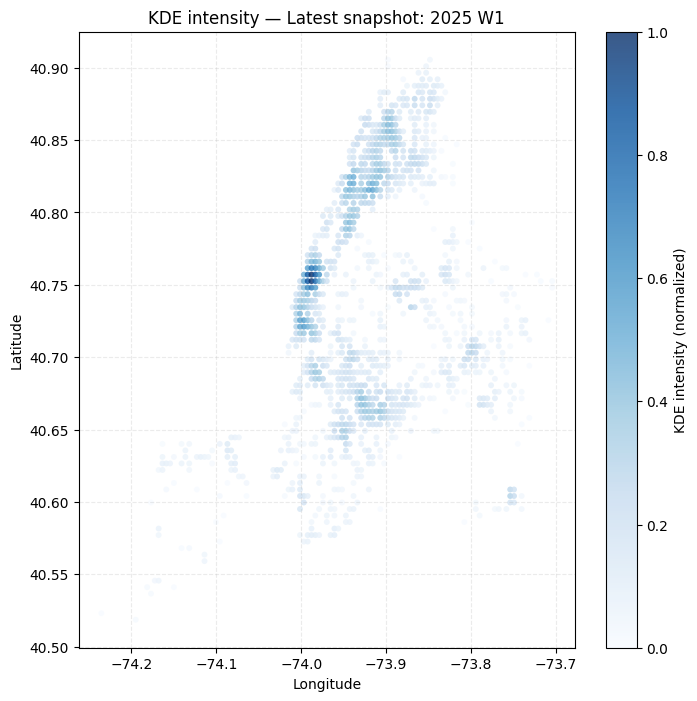

Saved: /content/fig_kde_intensity.png


In [30]:
paths = [
    "/content/final_modeling_features_with_hdbscan.csv",
    "/content/final_modeling_features_complete.csv",
    "/content/final_modeling_features.csv"
]
for p in paths:
    if os.path.exists(p):
        features_path = p
        break
else:
    raise FileNotFoundError("No final features CSV found.")

df_feat = pd.read_csv(features_path)
grid = pd.read_csv("/content/grid_cells.csv")

latest_year = int(df_feat['iso_year'].max())
latest_week = int(df_feat[df_feat['iso_year']==latest_year]['iso_week'].max())
df_latest = df_feat[(df_feat['iso_year']==latest_year) & (df_feat['iso_week']==latest_week)].merge(
    grid[['grid_id','centroid_lat','centroid_lon']], on='grid_id', how='left').dropna(subset=['centroid_lat','centroid_lon'])

if 'kde_norm' in df_latest.columns:
    vals = df_latest['kde_norm'].values
else:
    vals = df_latest['kde_score'].values
vals_norm = (vals - np.nanmin(vals)) / (np.nanmax(vals) - np.nanmin(vals) + 1e-12)

plt.figure(figsize=(8,8))
sc = plt.scatter(df_latest['centroid_lon'], df_latest['centroid_lat'],
                 c=vals_norm, cmap='Blues', s=18, alpha=0.8, edgecolors='none')
plt.colorbar(sc, label='KDE intensity (normalized)')
plt.title(f'KDE intensity — Latest snapshot: {latest_year} W{latest_week}')
plt.xlabel('Longitude'); plt.ylabel('Latitude')
plt.grid(alpha=0.25, linestyle='--')
out = "/content/fig_kde_intensity.png"
plt.savefig(out, dpi=300, bbox_inches='tight')
plt.show()
print("Saved:", out)

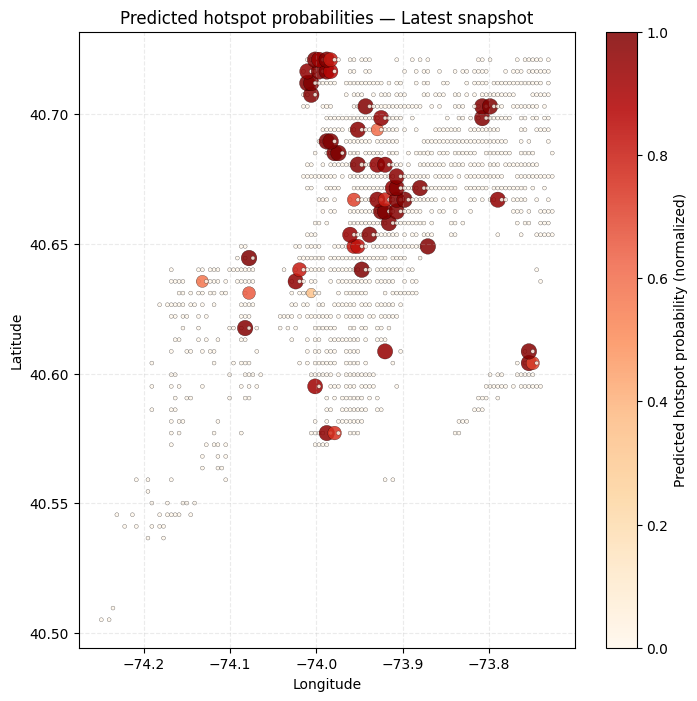

Saved: /content/fig_pred_prob.png


In [31]:
pred_path = "/content/pred_map_2024.csv"
if not os.path.exists(pred_path):
    raise FileNotFoundError(pred_path + " not found. Make sure predictions were saved.")

pred = pd.read_csv(pred_path)
if 'iso_year' in pred.columns:
    latest_year = int(pred['iso_year'].max())
    latest_week = int(pred[pred['iso_year']==latest_year]['iso_week'].max())
    pred = pred[(pred['iso_year']==latest_year) & (pred['iso_week']==latest_week)]

if 'centroid_lat' not in pred.columns:
    grid = pd.read_csv("/content/grid_cells.csv")
    pred = pred.merge(grid[['grid_id','centroid_lat','centroid_lon']], on='grid_id', how='left')

pred = pred.dropna(subset=['centroid_lat','centroid_lon'])

probs = pred['pred_prob'].astype(float).values
probs_norm = (probs - probs.min())/(probs.max()-probs.min()+1e-12)

plt.figure(figsize=(8,8))
sizes = 8 + probs_norm * 120
sc = plt.scatter(pred['centroid_lon'], pred['centroid_lat'], c=probs_norm, cmap='OrRd', s=sizes, alpha=0.85, edgecolor='k', linewidth=0.2)
plt.colorbar(sc, label='Predicted hotspot probability (normalized)')
plt.title(f'Predicted hotspot probabilities — Latest snapshot')
plt.xlabel('Longitude'); plt.ylabel('Latitude')
plt.grid(alpha=0.25, linestyle='--')
out = "/content/fig_pred_prob.png"
plt.savefig(out, dpi=300, bbox_inches='tight')
plt.show()
print("Saved:", out)

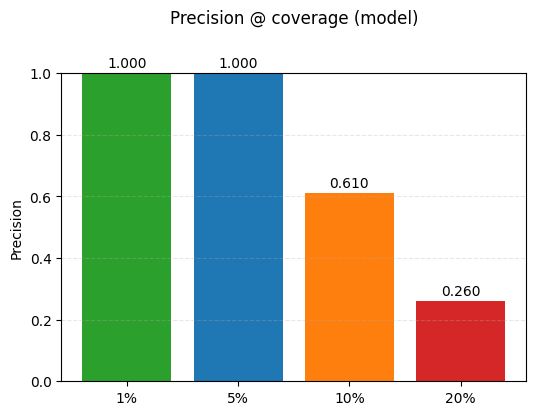

Saved: /content/fig_precision_at_k.png


In [40]:
pred_path = "/content/pred_map_2024.csv"
if not os.path.exists(pred_path):
    raise FileNotFoundError(pred_path + " not found.")
pred = pd.read_csv(pred_path)
if 'iso_year' in pred.columns:
    latest_year = int(pred['iso_year'].max())
    latest_week = int(pred[pred['iso_year']==latest_year]['iso_week'].max())
    pred = pred[(pred['iso_year']==latest_year)&(pred['iso_week']==latest_week)]
pred = pred.dropna(subset=['pred_prob','grid_id'])

def precision_at_k(probs, true, k):
    cutoff = np.quantile(probs, 1 - k)
    sel = probs >= cutoff
    return true[sel].sum() / sel.sum() if sel.sum()>0 else 0

ks = [0.01, 0.05, 0.10, 0.20]
labels = ['1%','5%','10%','20%']
values = []
for k in ks:
    val = precision_at_k(pred['pred_prob'].values, pred['hotspot'].values, k)
    values.append(val)

plt.figure(figsize=(6,4))
bars = plt.bar(labels, values, color=['#2ca02c','#1f77b4','#ff7f0e','#d62728'])
plt.ylim(0,1)
plt.ylabel('Precision')
plt.title('''Precision @ coverage (model)

''')
for rect, v in zip(bars, values):
    plt.text(rect.get_x()+rect.get_width()/2, v+0.02, f"{v:.3f}", ha='center')
out = "/content/fig_precision_at_k.png"
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.savefig(out, dpi=300, bbox_inches='tight')
plt.show()
print("Saved:", out)

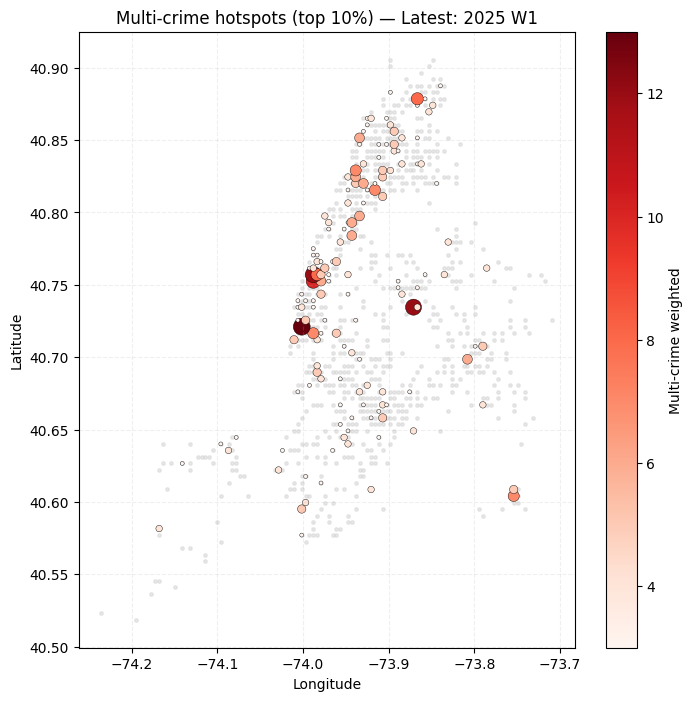

Saved: /content/fig_multicrime_hotspots.png


In [41]:
mc_path = "/content/multicrime_hotspots.csv"
if not os.path.exists(mc_path):
    raise FileNotFoundError(mc_path + " not found.")
mc = pd.read_csv(mc_path)
latest_year = int(mc['iso_year'].max())
latest_week = int(mc[mc['iso_year']==latest_year]['iso_week'].max())
mc_latest = mc[(mc['iso_year']==latest_year)&(mc['iso_week']==latest_week)].copy()

grid = pd.read_csv("/content/grid_cells.csv")
mc_map = mc_latest.merge(grid[['grid_id','centroid_lat','centroid_lon']], on='grid_id', how='left').dropna(subset=['centroid_lat','centroid_lon'])
top = mc_map[mc_map['multi_hotspot']==1].copy()
if len(top)==0:
    top = mc_map.sort_values('multi_crime_weighted', ascending=False).head(300)

sizes = 8 + (top['multi_crime_weighted'] - top['multi_crime_weighted'].min())/(top['multi_crime_weighted'].max()-top['multi_crime_weighted'].min()+1e-12) * 140

plt.figure(figsize=(8,8))
plt.scatter(mc_map['centroid_lon'], mc_map['centroid_lat'], c='lightgrey', s=6, alpha=0.5, label='All grids')
sc = plt.scatter(top['centroid_lon'], top['centroid_lat'], c=top['multi_crime_weighted'], cmap='Reds', s=sizes, edgecolor='k', linewidth=0.3)
plt.colorbar(sc, label='Multi-crime weighted')
plt.title(f'Multi-crime hotspots (top 10%) — Latest: {latest_year} W{latest_week}')
plt.xlabel('Longitude'); plt.ylabel('Latitude')
plt.grid(alpha=0.2, linestyle='--')
out = "/content/fig_multicrime_hotspots.png"
plt.savefig(out, dpi=300, bbox_inches='tight')
plt.show()
print("Saved:", out)

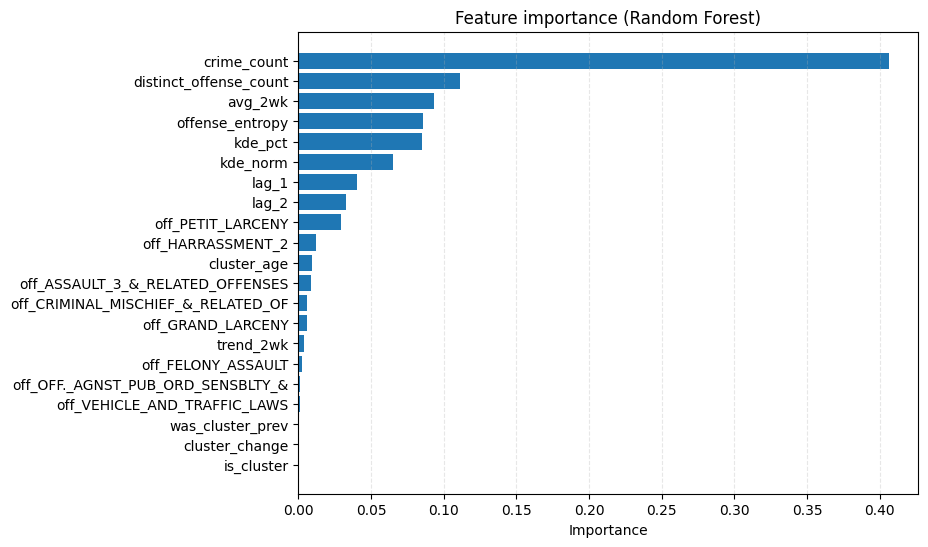

Saved: /content/fig_feature_importance.png


In [43]:
model_path = "/content/calibrated_rf_sigmoid.joblib"
if not os.path.exists(model_path):
    raise FileNotFoundError(model_path + " not found.")

cal = joblib.load(model_path)
try:
    rf = cal.calibrated_classifiers_[0].estimator
except Exception:
    try:
        rf = joblib.load("/content/rf_base.joblib")
    except Exception:
        raise RuntimeError("Could not extract RF estimator. Ensure model saved properly.")

feat_csv = "/content/final_modeling_features_complete.csv"
if not os.path.exists(feat_csv):
    raise FileNotFoundError(feat_csv + " not found.")
df_feat = pd.read_csv(feat_csv)
exclude = ['grid_id','iso_year','iso_week','hotspot','kde_score','kde_pct']
features = [c for c in df_feat.columns if c not in exclude]
importances = rf.feature_importances_
if len(importances) != len(features):
    features = ['crime_count','lag_1','lag_2','avg_2wk','trend_2wk',
                'kde_norm','kde_pct','is_cluster','was_cluster_prev','cluster_age','cluster_change',
                'distinct_offense_count','offense_entropy',
                'off_ASSAULT_3_&_RELATED_OFFENSES','off_CRIMINAL_MISCHIEF_&_RELATED_OF',
                'off_FELONY_ASSAULT','off_GRAND_LARCENY','off_HARRASSMENT_2',
                'off_OFF._AGNST_PUB_ORD_SENSBLTY_&','off_PETIT_LARCENY','off_VEHICLE_AND_TRAFFIC_LAWS']
fi = pd.DataFrame({'feature': features, 'importance': importances})
fi = fi.sort_values('importance', ascending=True)

plt.figure(figsize=(8,6))
plt.barh(fi['feature'], fi['importance'], color='tab:blue')
plt.xlabel('Importance')
plt.title('Feature importance (Random Forest)')
plt.grid(axis='x', alpha=0.3, linestyle='--')
out = "/content/fig_feature_importance.png"
plt.savefig(out, dpi=300, bbox_inches='tight')
plt.show()
print("Saved:", out)